In [10]:
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm

import scanpy as sc
from sklearn.metrics.cluster import *
import seaborn as sns
from matplotlib import pyplot as plt


In [ ]:
%%time

pred = pd.read_pickle("./MCA_MTL_Celltype/Test/test_mode_pred_prob.p", compression='xz')
pred.shape

CPU times: user 46 s, sys: 0 ns, total: 46 s
Wall time: 46 s


(1834, 179344)

In [ ]:
test_target = pd.read_pickle("./MCA_MTL_Celltype/Test/test_target_prob.p", compression='xz')
print(test_target.shape)

(1834, 179344)


In [14]:
anno = pd.read_csv("MCA_cellatlas.annotation.20210125.txt", sep='\t', index_col=0, header=0).loc[pred.columns]
print(anno.shape)
anno[:3]

(179344, 3)


,Species,Celltype,Cellcluster
AdultAdrenalGland_1.AACCTAAGATGGGTAATG,Mouse,Endothelial_Mouse48,Endothelial
AdultAdrenalGland_1.AACCTAATCTCTCTCGCA,Mouse,Endothelial_Mouse48,Endothelial
AdultAdrenalGland_1.AACCTACAACAATGCGGA,Mouse,Endothelial_Mouse48,Endothelial


In [ ]:
adata = sc.read_h5ad("./d2_MCL/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 179344 × 1834
    obs: 'Species', 'Celltype', 'Cellcluster', 'Idents'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [16]:
adata0 = adata.copy()
adata0 = adata0[:,adata0.var['highly_variable']]
adata0

View of AnnData object with n_obs × n_vars = 179344 × 549
    obs: 'Species', 'Celltype', 'Cellcluster', 'Idents'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [17]:
pred_highly = pred[pred.index.isin(adata0.var.index)]
print(pred_highly.shape)
test_target_highly = test_target[test_target.index.isin(adata0.var.index)]
print(test_target_highly.shape)

(549, 179344)
(549, 179344)


In [18]:
threshold = 0.1109  # 可调整阈值
binary_pred_highly = (pred_highly >= threshold).astype(int)  # 二值化

In [19]:
binary_pred_highly.iloc[:2,:3]

,AdultAdrenalGland_1.AACCTAAGATGGGTAATG,AdultAdrenalGland_1.AACCTAATCTCTCTCGCA,AdultAdrenalGland_1.AACCTACAACAATGCGGA
1110028F18Rik,1,1,1
1700001D01Rik,0,0,0


In [20]:
test_target_highly.iloc[:2,:3]

,AdultAdrenalGland_1.AACCTAAGATGGGTAATG,AdultAdrenalGland_1.AACCTAATCTCTCTCGCA,AdultAdrenalGland_1.AACCTACAACAATGCGGA
1110028F18Rik,0.0,0.0,0.0
1700001D01Rik,0.0,0.0,0.0


In [ ]:
y_pred = binary_predtest_highly.to_numpy().values.flatten()

In [22]:
y_true = test_target_highly.astype(int).values.flatten()  # 展平为一维数组
y_pred = binary_pred_highly.values.flatten()

In [23]:
binary_pred_highly.stack().value_counts()

0    50583914
1    47875942
Name: count, dtype: int64

In [24]:
y_true

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
#2. 计算混淆矩阵​​
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("混淆矩阵:\n", cm)

混淆矩阵:
 [[48216894 26691372]
 [ 2367020 21184570]]


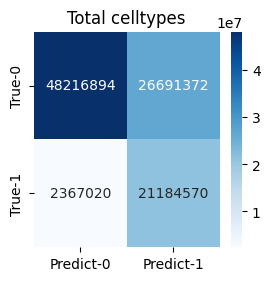

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设cm是混淆矩阵数据
plt.figure(figsize=(3, 2.8))
heatmap = sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    annot_kws={"size": 10},  # 内部数字标签
    xticklabels=['Predict-0', 'Predict-1'],
    yticklabels=['True-0', 'True-1']
)

# 设置轴标签和标题字体
#plt.xlabel('Prediction label', fontsize=12)
#plt.ylabel('True label', fontsize=12)
plt.title('Total celltypes', fontsize=12)
plt.xticks(fontsize=12)                
plt.yticks(fontsize=12)

# 设置刻度标签字体
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)


plt.show()

In [28]:
TN, FP, FN, TP = cm.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
sample = 47875942/50583914
   
print(f"准确率: {accuracy:.2f}")
print(f"精确率: {precision:.2f}")
print(f"召回率: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"正负样本比例:{sample:.2f}")

准确率: 0.70
精确率: 0.44
召回率: 0.90
F1-score: 0.59
正负样本比例:0.95


In [29]:
recall

0.8994963821975501

In [30]:
df_total = pd.DataFrame({'Accuracy': [accuracy],
                       'Precision':[precision],
                       'Recall':[recall],
                       'F1-score':[f1],
                         'ratio(1/0)':[sample]
                        })
df_total

,Accuracy,Precision,Recall,F1-score,ratio(1/0)
0,0.704871,0.442489,0.899496,0.593177,0.946466


In [31]:
df_total.T

,0
Accuracy,0.704871
Precision,0.442489
Recall,0.899496
F1-score,0.593177
ratio(1/0),0.946466


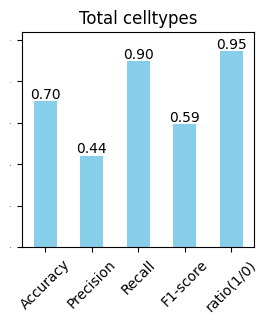

In [ ]:
ax = df_total.T.plot(kind='bar', color='skyblue', figsize=(3,2.8),legend=False)
plt.xticks(rotation=0)  # 避免横轴标签重叠
ax.set_ylim(top=max(df_total.T.values) * 1.1)  # 增加15%的顶部空间[4](@ref)
plt.xticks(rotation=45)  # 倾斜45度

plt.xticks(fontsize=10)                
plt.yticks(fontsize=0) 
##plt.legend(title='Sample')
plt.title("Total celltypes",fontsize=12)

# 添加数值标签（保留两位小数）
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')  

plt.savefig('./Figure5/total_stat.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
y_scores =  pred_highly.values.flatten()

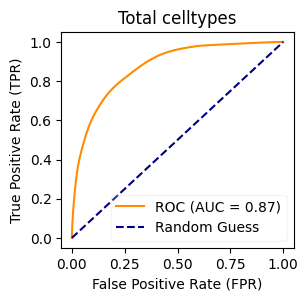

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 假设已有真实标签y_true和预测概率y_scores
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线

plt.figure(figsize=(3, 2.8))
plt.xticks(fontsize=10)                
plt.yticks(fontsize=10) 

plt.plot(fpr, tpr, color='darkorange', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Total celltypes',fontsize=12)
plt.legend(loc='lower right',frameon=True,framealpha=0.2)
plt.savefig('./Figure5/total_roc.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.xticks(fontsize=10)                
plt.yticks(fontsize=10) 
##plt.legend(title='Sample')
plt.title("Total celltypes")

# 添加数值标签（保留两位小数）
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')  

plt.savefig('./Figure5/total_stat.png', dpi=300, bbox_inches='tight')
plt.show()

In [145]:
cell_mask = anno[anno['Celltype'].isin(['Muscle_Mouse98'])].index
#cell_mask

In [78]:
test_target_highly.loc[:, cell_mask].astype(int).values.flatten()

array([0, 0, 0, ..., 0, 0, 0])

In [146]:
tmp_y_pred_cell = binary_pred_highly.loc[:, cell_mask]
tmp_y_pred_cell.stack().value_counts()

1    24679
0    20888
Name: count, dtype: int64

In [ ]:

cell_types = 'Muscle_Mouse98'

# 按细胞类型分组计算
for cell_type in np.unique(cell_types):
    cell_mask = anno[anno['Celltype'] == (cell_type)].index
    y_true_cell = test_target_highly.loc[:, cell_mask].astype(int).values.flatten()
    y_pred_cell = binary_pred_highly.loc[:, cell_mask].values.flatten()
    cm_cell = confusion_matrix(y_true_cell, y_pred_cell)
    print(f"细胞类型 {cell_type} 的混淆矩阵:\n", cm_cell)

细胞类型 Muscle_Mouse98 的混淆矩阵:
 [[20197 12913]
 [  691 11766]]


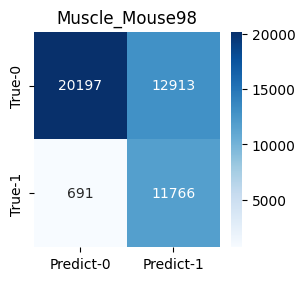

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设cm是混淆矩阵数据
plt.figure(figsize=(3, 2.8))
heatmap = sns.heatmap(
    cm_cell, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    annot_kws={"size": 10},  # 内部数字标签
    xticklabels=['Predict-0', 'Predict-1'],
    yticklabels=['True-0', 'True-1']
)


plt.title('Muscle_Mouse98', fontsize=12)
plt.xticks(fontsize=12)                
plt.yticks(fontsize=12)

# 设置刻度标签字体
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

plt.savefig('./Figure5/muscle_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [147]:
TN, FP, FN, TP = cm_cell.ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
sample = 24679/20888

print(f"准确率: {accuracy:.2f}")
print(f"精确率: {precision:.2f}")
print(f"召回率: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"正负样本比例:{sample:.2f}")

准确率: 0.70
精确率: 0.48
召回率: 0.94
F1-score: 0.63
正负样本比例:1.18


In [190]:
df_cell = pd.DataFrame({'Accuracy': [accuracy],
                       'Precision':[precision],
                       'Recal':[recall],
                       'F1-score':[f1],
                       'ratio(1/0)':[sample]
                       })
df_cell

,Accuracy,Precision,Recal,F1-score,ratio(1/0)
0,0.701451,0.476762,0.944529,0.633671,1.181492


In [204]:
max(df_cell.T.values) *3

array([3.5444753])

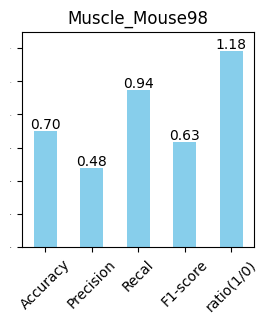

In [ ]:
#ax = df_total.T.plot(kind='bar', color='skyblue', figsize=(3,3.2),legend=False)
ax_cell = df_cell.T.plot(kind='bar', color='skyblue', figsize=(3,2.8),legend=False)
plt.xticks(rotation=0)  # 避免横轴标签重叠
ax_cell.set_ylim(top=max(df_cell.T.values) * 1.1)  # 增加15%的顶部空间[4](@ref)
#ax.set_ylim(0,1.5) 
plt.xticks(rotation=45)  # 倾斜45度

plt.xticks(fontsize=10)                
plt.yticks(fontsize=0) 
##plt.legend(title='Sample')
plt.title("Muscle_Mouse98",fontsize=12)

# 添加数值标签（保留两位小数）
for container in ax_cell.containers:
    ax_cell.bar_label(container, fmt='%.2f', label_type='edge')  

plt.savefig('./Figure5/Muscle_Mouse98_stat.png', dpi=300, bbox_inches='tight')
#plt.show()

In [ ]:
 y_true_cell = test_target_highly.loc[:, cell_mask].astype(int).values.flatten()
 y_pred_cell = binary_pred_highly.loc[:, cell_mask].values.flatten()

In [92]:
cell_mask = anno[anno['Celltype'] == 'Muscle_Mouse98'].index
tmp = pd.DataFrame(pred_highly)
tmp = tmp.loc[:,cell_mask]

In [93]:
y_scores_cell =  tmp.values.flatten()

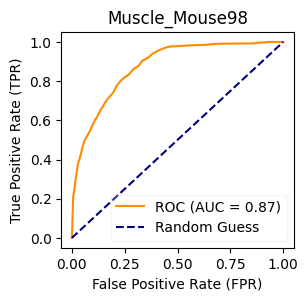

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 假设已有真实标签y_true和预测概率y_scores
fpr, tpr, thresholds = roc_curve(y_true_cell, y_scores_cell)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线

plt.figure(figsize=(3, 2.8))
plt.xticks(fontsize=10)                
plt.yticks(fontsize=10) 

plt.plot(fpr, tpr, color='darkorange', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Muscle_Mouse98',fontsize=12)
plt.legend(loc='lower right',frameon=True,framealpha=0.2)
plt.savefig('./Figure5/Muscle_Mouse98_roc.png', dpi=300, bbox_inches='tight')
plt.show()